# Toy demonstrations for SoftAD and related methods

In [1]:
# External modules.
import copy
from matplotlib import colormaps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

# Internal modules.
from setup.directories import img_path
from setup.data import get_dataloader
from setup.eval import eval_loss_acc
from setup.losses import Loss_Flood, Loss_SoftAD, get_named_loss
from setup.results import my_ext
from setup.sunhuber import rho, rho_d1
from setup.utils import makedir_safe

In [2]:
# Create directory to save figures.
makedir_safe(img_path)

## Some deterministic examples

Let us start with a simple one-dimensional example, without any stochasticity, to keep things simple. First, let us look at a quadratic function.

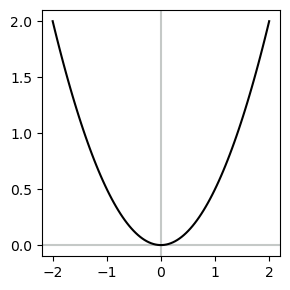

In [3]:
# Basic objective function "f", a 1D quadratic.

def f(x):
    return x**2.0 / 2.0

def f_d1(x):
    return x

def f_f2(x):
    return 1.0

# Visualize this function.
x = np.linspace(-2.0, 2.0, 100)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.axhline(y=0.0, color="xkcd:silver")
ax.axvline(x=0.0, color="xkcd:silver")
ax.plot(x, f(x=x), color="xkcd:black", linestyle="solid")
#ax.set_yticks([-1.0, 0.0, 1.0])
#ax.set_yticklabels([r"-1", r"0", r"1"])
#ax.set_xticks([-1.0, 0.0, 1.0])
#ax.set_xticklabels([r"$\theta-$"+str(1),
#                    r"$\theta$",
#                    r"$\theta+$"+str(1)])
#ax.tick_params(labelsize=my_fontsize)
plt.tight_layout()
fname = os.path.join(img_path, "demo_quadratic_1D.{}".format(my_ext))
plt.savefig(fname=fname)
plt.show()


Let's plot how the gradients change when passed through a SoftAD-type transformation.

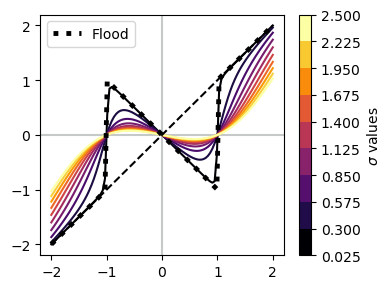

In [4]:
# Slope plotting (modifying sigma).
x = np.linspace(-2.0, 2.0, 100)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.axhline(y=0.0, color="xkcd:silver")
ax.axvline(x=0.0, color="xkcd:silver")

## Modified slopes.
sigmas = np.linspace(0.025, 2.5, 10)
theta = 0.5
cmap = colormaps.get_cmap("inferno")
colours = cmap(np.linspace(0.0, 1.0, len(sigmas)))
for i, sigma in enumerate(sigmas):
    y = rho_d1((f(x=x)-theta)/sigma) * f_d1(x=x)
    ax.plot(x, y, color=colours[i], linestyle="solid")
y_flood = np.sign(f(x=x)-theta) * f_d1(x=x)
ax.plot(x, y_flood, color="xkcd:black", linestyle="dotted", linewidth=3.5, label="Flood")

## Raw slopes.
ax.plot(x, f_d1(x=x), color="xkcd:black", linestyle="dashed")

norm = BoundaryNorm(sigmas, cmap.N)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = fig.colorbar(sm, ax=ax)
cb.set_label(label=r"$\sigma$ values")
ax.legend(loc="upper left")
plt.tight_layout()
fname = os.path.join(img_path, "demo_quadratic_SoftAD_oversigma.{}".format(my_ext))
plt.savefig(fname=fname)
plt.show()

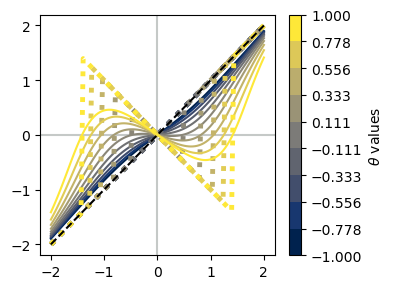

In [5]:
# Slope plotting (modifying theta).
x = np.linspace(-2.0, 2.0, 100)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.axhline(y=0.0, color="xkcd:silver")
ax.axvline(x=0.0, color="xkcd:silver")

## Modified slopes.
sigma = 1.0
thetas = np.linspace(-1.0, 1.0, 10)
cmap = colormaps.get_cmap("cividis")
colours = cmap(np.linspace(0.0, 1.0, len(thetas)))
for i, theta in enumerate(thetas):
    y = rho_d1((f(x=x)-theta)/sigma) * f_d1(x=x)
    ax.plot(x, y, color=colours[i], linestyle="solid")
    y_flood = np.sign(f(x=x)-theta) * f_d1(x=x)
    ax.plot(x, y_flood, color=colours[i], linestyle="dotted", linewidth=3.5)

## Raw slopes.
ax.plot(x, f_d1(x=x), color="xkcd:black", linestyle="dashed")

norm = BoundaryNorm(thetas, cmap.N)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = fig.colorbar(sm, ax=ax)
cb.set_label(label=r"$\theta$ values")
plt.tight_layout()
fname = os.path.join(img_path, "demo_quadratic_SoftAD_overtheta.{}".format(my_ext))
plt.savefig(fname=fname)
plt.show()

It is quite clear how the key parameters ($\theta$ and $\sigma$) impact our criterion. The next thing to consider is how a gradient descent procedure is affected by this. For some representative and easy to interpret results, see the following settings (all with step size = 0.1):

- $x_{0}$: 2.0, $\theta$: 1.0, $\sigma$ 0.1, 
- $x_{0}$: 0.5, $\theta$: 2.0, $\sigma$ 0.1
- $x_{0}$: -0.1, $\theta$: 2.0, $\sigma$ 1.0
- $x_{0}$: -2.0, $\theta$: 0.5, $\sigma$ 1.0

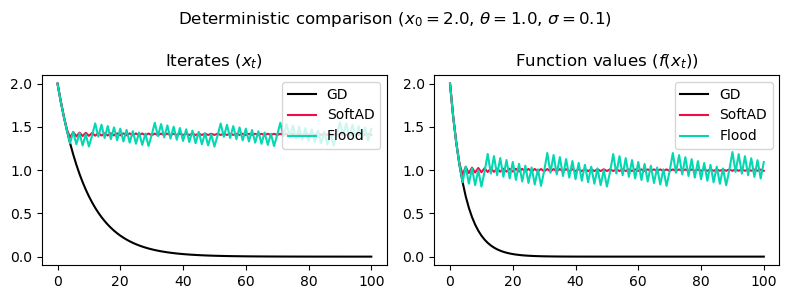

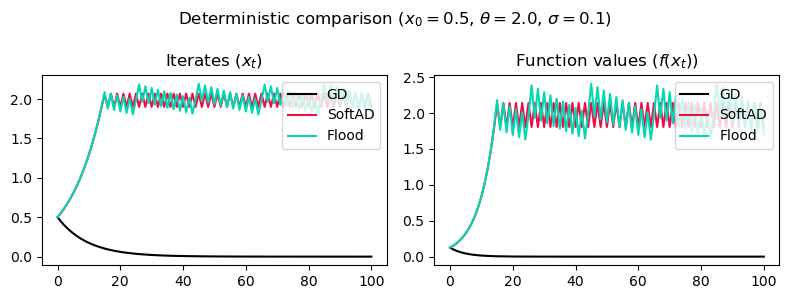

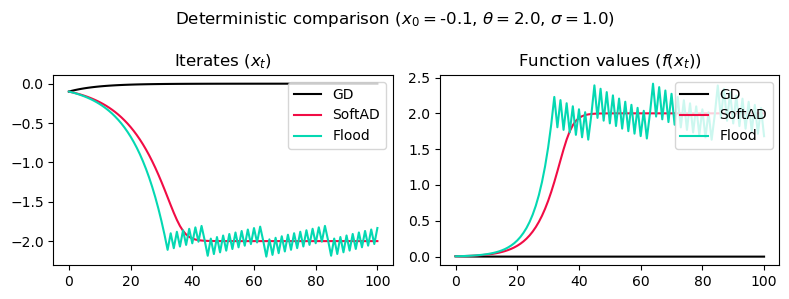

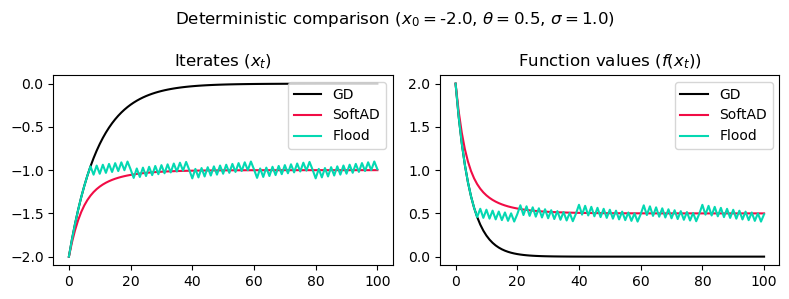

In [6]:
# Run a simple gradient descent routine.

## Algorithm setups to try, using (x_init, theta, sigma) tuples.
setups = [(2.0, 1.0, 0.1),
          (0.5, 2.0, 0.1),
          (-0.1, 2.0, 1.0),
          (-2.0, 0.5, 1.0)]
#x_init = -2.0
#theta = 0.5
#sigma = 1.0
step_size = 0.1
num_iters = 100

## Run the algorithms over all setups of interest.
counter = 0
for (x_init, theta, sigma) in setups:

    ## Initialize.
    x_gd = copy.copy(x_init)
    x_softad = copy.copy(x_init)
    x_flood = copy.copy(x_init)
    
    ## Storage setup.
    iterates_gd = [copy.copy(x_gd)]
    iterates_softad = [copy.copy(x_softad)]
    iterates_flood = [copy.copy(x_flood)]
    fnval_gd = [f(x=x_gd)]
    fnval_softad = [f(x=x_softad)]
    fnval_flood = [f(x=x_flood)]

    ## Run algorithm as specified.
    for t in range(num_iters):
        x_gd -= step_size * f_d1(x=x_gd)
        x_softad -= step_size * rho_d1((f(x=x_softad)-theta)/sigma) * f_d1(x=x_softad)
        x_flood -= step_size * np.sign(f(x=x_flood)-theta) * f_d1(x=x_flood)
        iterates_gd += [copy.copy(x_gd)]
        iterates_softad += [copy.copy(x_softad)]
        iterates_flood += [copy.copy(x_flood)]
        fnval_gd += [f(x=x_gd)]
        fnval_softad += [f(x=x_softad)]
        fnval_flood += [f(x=x_flood)]

    ## Visualize the stored values.
    iterates_gd = np.array(iterates_gd)
    iterates_softad = np.array(iterates_softad)
    iterates_flood = np.array(iterates_flood)
    fnval_gd = np.array(fnval_gd)
    fnval_softad = np.array(fnval_softad)
    fnval_flood = np.array(fnval_flood)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=False)
    ax1.plot(np.arange(0, num_iters+1, 1), iterates_gd,
             color="xkcd:black", linestyle="solid", label="GD")
    ax1.plot(np.arange(0, num_iters+1, 1), iterates_softad,
             color="xkcd:pinkish red", linestyle="solid", label="SoftAD")
    ax1.plot(np.arange(0, num_iters+1, 1), iterates_flood,
             color="xkcd:aquamarine", linestyle="solid", label="Flood")
    ax2.plot(np.arange(0, num_iters+1, 1), fnval_gd,
             color="xkcd:black", linestyle="solid", label="GD")
    ax2.plot(np.arange(0, num_iters+1, 1), fnval_softad,
             color="xkcd:pinkish red", linestyle="solid", label="SoftAD")
    ax2.plot(np.arange(0, num_iters+1, 1), fnval_flood,
             color="xkcd:aquamarine", linestyle="solid", label="Flood")
    ax1.set_title("Iterates ($x_{t}$)")
    ax2.set_title(r"Function values ($f(x_{t})$)")
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    fig.suptitle(
        r"Deterministic comparison ($x_0=${}, $\theta=${}, $\sigma=${})".format(str(x_init),
                                                                                 str(theta),
                                                                                 str(sigma))
    )
    plt.tight_layout()
    fname = os.path.join(img_path, "demo_quadratic_GDvsAD_{}.{}".format(counter, my_ext))
    plt.savefig(fname=fname)
    plt.show()
    counter += 1

Next, let us introduce some stochasticity, i.e., generate a data set so that we have multiple points at which to evaluate losses; this will really highlight the differences between Flood and Soft-AD.

## 2D location estimation

As an illustrative example showing how the "weighted sum of gradients" differs from the hard-switch flooding gradient, we consider minimizing sums of norms (squared?) in two dimensions.

In [7]:
# Clerical setup.

## Seed control.
random_seed = 22993514079364 # fixed seed.
#random_seed = np.random.SeedSequence().entropy # uncomment for fresh seeds.

## Seed the random generator (numpy and torch).
rg = np.random.default_rng(random_seed)
rg_torch = torch.manual_seed(seed=random_seed)

## Device setup.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device.".format(device))

Using cuda device.


In [8]:
# Generate a handful of points.
data_mean = np.array([0.0, 0.0])
data_cov = np.array(([1.0, 0.0],[0.0, 1.0]))
data_size = 8
X = rg.multivariate_normal(mean=data_mean, cov=8*data_cov, size=data_size)
w_star = np.mean(X, axis=0)
losses_star = np.mean(np.array([ np.linalg.norm(w_star-X[i,:])**2 for i in range(len(X)) ]))
print(losses_star)

9.374522601254057


In [9]:
# Compute gradients for each point (assuming loss is squared l2 norm).
theta = losses_star * 1.5
sigma = 1.0
step_size = 0.75
w_1 = np.array([-4, 4])
w_2 = np.array([1, 1])
losses_1 = np.array([ np.linalg.norm(w_1-X[i,:])**2 for i in range(len(X)) ])
losses_2 = np.array([ np.linalg.norm(w_2-X[i,:])**2 for i in range(len(X)) ])
grads_raw_1 = w_1 - X
grads_raw_2 = w_2 - X
scalars_softad_1 = rho_d1((losses_1-theta)/sigma)
scalars_softad_2 = rho_d1((losses_2-theta)/sigma)
grads_softad_1 = scalars_softad_1.reshape((len(X),1)) * grads_raw_1
grads_softad_2 = scalars_softad_2.reshape((len(X),1)) * grads_raw_2
grad_flood_1 = np.sign(np.mean(losses_1)-theta) * np.mean(grads_raw_1, axis=0)
grad_flood_2 = np.sign(np.mean(losses_2)-theta) * np.mean(grads_raw_2, axis=0)
update_flood_1 = np.copy(-step_size*grad_flood_1)
update_flood_2 = np.copy(-step_size*grad_flood_2)
updates_softad_1 = np.copy(-step_size*grads_softad_1)
updates_softad_2 = np.copy(-step_size*grads_softad_2)
update_softad_1 = np.mean(updates_softad_1, axis=0)
update_softad_2 = np.mean(updates_softad_2, axis=0)
w_flood_1 = np.copy(w_1 + update_flood_1)
w_flood_2 = np.copy(w_2 + update_flood_2)

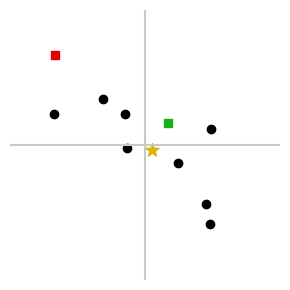

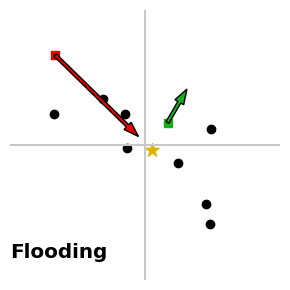

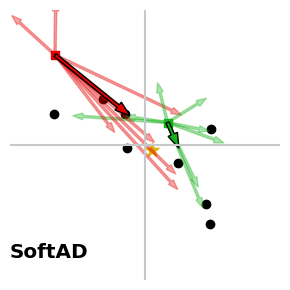

In [10]:
# Visualize the data.

## First, just plot the data and points.
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X[:,0], X[:,1], marker="o", color="xkcd:black")
ax.scatter(w_star[0], w_star[1], marker="*", color="xkcd:gold", s=10**2)
ax.scatter(w_1[0], w_1[1], marker="s", color="xkcd:red")
ax.scatter(w_2[0], w_2[1], marker="s", color="xkcd:green")
border_width = 6
ax.set_ylim(bottom=-border_width, top=border_width)
ax.set_xlim(left=-border_width, right=border_width)
ax.set_axis_off()
fname = os.path.join(img_path, "sims_2Dmean_points.{}".format(my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

## Next, a flood-based update directions.
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X[:,0], X[:,1], marker="o", color="xkcd:black")
ax.scatter(w_star[0], w_star[1], marker="*", color="xkcd:gold", s=10**2)
ax.scatter(w_1[0], w_1[1], marker="s", color="xkcd:red")
ax.scatter(w_2[0], w_2[1], marker="s", color="xkcd:green")
ax.arrow(x=w_1[0], y=w_1[1],
         dx=update_flood_1[0], dy=update_flood_1[1],
         length_includes_head=False,
         width=0.15, fc="xkcd:red")
ax.arrow(x=w_2[0], y=w_2[1],
         dx=update_flood_2[0], dy=update_flood_2[1],
         length_includes_head=False,
         width=0.15, fc="xkcd:green")
border_width = 6
ax.set_ylim(bottom=-border_width, top=border_width)
ax.set_xlim(left=-border_width, right=border_width)
ax.set_axis_off()
ax.set_title("Flooding", loc="left", x=0.0, y=0.05,
             fontsize="x-large", fontweight="bold")
fname = os.path.join(img_path, "sims_2Dmean_flood.{}".format(my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

## Finally do SoftAD based update directions.
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X[:,0], X[:,1], marker="o", color="xkcd:black")
ax.scatter(w_star[0], w_star[1], marker="*", color="xkcd:gold", s=10**2)
ax.scatter(w_1[0], w_1[1], marker="s", color="xkcd:red")
ax.scatter(w_2[0], w_2[1], marker="s", color="xkcd:green")
for i in range(len(X)):
    ax.arrow(x=w_1[0], y=w_1[1],
             dx=updates_softad_1[i,0], dy=updates_softad_1[i,1],
             length_includes_head=False,
             alpha=0.35,
             width=0.1, color="xkcd:red")
    ax.arrow(x=w_2[0], y=w_2[1],
             dx=updates_softad_2[i,0], dy=updates_softad_2[i,1],
             length_includes_head=False,
             alpha=0.35,
             width=0.1, color="xkcd:green")
ax.arrow(x=w_1[0], y=w_1[1],
         dx=update_softad_1[0], dy=update_softad_1[1],
         length_includes_head=False,
         width=0.15, fc="xkcd:red")
ax.arrow(x=w_2[0], y=w_2[1],
         dx=update_softad_2[0], dy=update_softad_2[1],
         length_includes_head=False,
         width=0.15, fc="xkcd:green")
border_width = 6
ax.set_ylim(bottom=-border_width, top=border_width)
ax.set_xlim(left=-border_width, right=border_width)
ax.set_axis_off()
ax.set_title("SoftAD", loc="left", x=0.0, y=0.05,
             fontsize="x-large", fontweight="bold")
fname = os.path.join(img_path, "sims_2Dmean_softad.{}".format(my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

## Linear binary classification

In [11]:
# Clerical setup.

## Seed control.
random_seed = 22993514079364 # fixed seed.
#random_seed = np.random.SeedSequence().entropy # uncomment for fresh seeds.

## Seed the random generator (numpy and torch).
rg = np.random.default_rng(random_seed)
rg_torch = torch.manual_seed(seed=random_seed)

## Device setup.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device.".format(device))

Using cuda device.


In [12]:
# Dataset parameters ("two Gaussians").
dataset_paras = {
    "rg": rg,
    "dimension": 2,
    "bs_tr": 100,
    "bs_va": 100,
    "bs_te": 20000,
    "n_tr": 100,
    "n_va": 100,
    "n_te": 20000,
    "label_noise": 0.0
}
dataset_name = "gaussian"

In [13]:
# Define a simple linear model.
class Model_Linear_Binary(nn.Module):
    '''
    Simple linear model for binary classification.
    (assumes cross entropy loss, so has two outputs)
    '''
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 2)
        return None
    
    def forward(self, x):
        return self.linear(x)

A few interesting experimental setups:

- `flood_level`: 0.1, `theta`: 0.1, `sigma`: 1.0
- `flood_level`: 0.1, `theta`: 0.1, `sigma`: 0.1
- `flood_level`: 0.1, `theta`: 0.1, `sigma`: 2.0
- `flood_level`: 0.15, `theta`: 0.15, `sigma`: 1.0 (this setting allows for slight difference in ERM vs Flood)
`flood_level`: 0.25, `theta`: 0.25, `sigma`: 1.0 (this setting allows for larger differences)

Trial: 0
dtypes (tr): torch.float32, torch.uint8
dtypes (va): torch.float32, torch.uint8
dtypes (te): torch.float32, torch.uint8


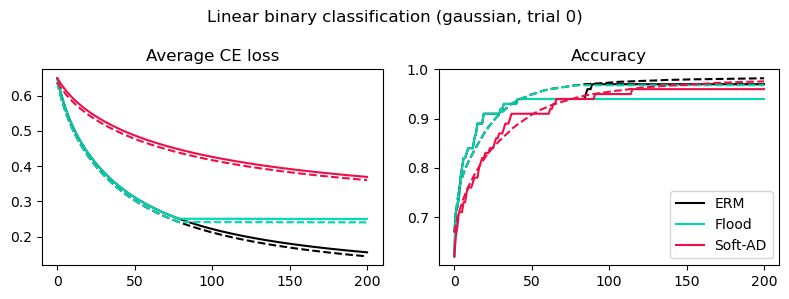

In [14]:
# Specify number of independent trials and epochs to do.
num_trials = 1
num_epochs = 200

final_losses_tr_erm = []
final_losses_tr_flood = []
final_losses_tr_softad = []
final_losses_te_erm = []
final_losses_te_flood = []
final_losses_te_softad = []
final_accs_tr_erm = []
final_accs_tr_flood = []
final_accs_tr_softad = []
final_accs_te_erm = []
final_accs_te_flood = []
final_accs_te_softad = []

# Begin main loop.
for trial in range(num_trials):

    print("Trial:", trial)

    #Prepare data loaders based on the "two Gaussians" dataset.
    dl_tr, eval_dl_tr, eval_dl_va, eval_dl_te = get_dataloader(
        dataset_name=dataset_name,
        dataset_paras=dataset_paras,
        device=device
    )

    # Construct the models.
    model_erm = Model_Linear_Binary(num_features=2).to(device)
    model_flood = copy.deepcopy(model_erm).to(device)
    model_softad = copy.deepcopy(model_flood).to(device)

    # Construct the optimizer.
    opt_paras = {"weight_decay": 0.0,
                 "lr": 1e-1,
                 "momentum": 0.0}
    optimizer_erm = SGD(params=model_erm.parameters(), **opt_paras)
    optimizer_flood = SGD(params=model_flood.parameters(), **opt_paras)
    optimizer_softad = SGD(params=model_softad.parameters(), **opt_paras)

    # Specify loss function.
    loss_name = "CrossEntropy"
    loss_fn = get_named_loss(loss_name=loss_name, loss_paras={}, reduction="mean")
    loss_fn_erm = get_named_loss(loss_name=loss_name, loss_paras={}, reduction="mean")
    loss_fn_flood = Loss_Flood(flood_level=0.25, loss_name=loss_name, loss_paras={})
    loss_fn_softad = Loss_SoftAD(theta=0.25, sigma=1.0, eta=1.0,
                                 loss_name=loss_name, loss_paras={})
    
    # Set up storage and begin train/eval loop for current trial.
    losses_tr_erm = []
    losses_tr_flood = []
    losses_tr_softad = []
    losses_te_erm = []
    losses_te_flood = []
    losses_te_softad = []
    accs_tr_erm = []
    accs_tr_flood = []
    accs_tr_softad = []
    accs_te_erm = []
    accs_te_flood = []
    accs_te_softad = []
    
    for epoch in range(-1, num_epochs):
        
        # Training step.
        if epoch >= 0:
            model_erm.train()
            model_flood.train()
            model_softad.train()
            for X, Y in dl_tr:
                l_erm = loss_fn_erm(model_erm(X), Y)
                l_flood = loss_fn_flood(model_flood(X), Y)
                l_softad = loss_fn_softad(model_softad(X), Y)
                optimizer_erm.zero_grad()
                optimizer_flood.zero_grad()
                optimizer_softad.zero_grad()
                l_erm.backward()
                l_flood.backward()
                l_softad.backward()
                with torch.no_grad():
                    optimizer_erm.step()
                    optimizer_flood.step()
                    optimizer_softad.step()
        
        # Evaluation step.
        model_erm.eval()
        model_flood.eval()
        model_softad.eval()
        with torch.no_grad():
            
            # Evaluate on training data.
            loss_tr_erm, acc_tr_erm = eval_loss_acc(model=model_erm,
                                                    data_loader=eval_dl_tr,
                                                    loss_fn=loss_fn)
            loss_tr_flood, acc_tr_flood = eval_loss_acc(model=model_flood,
                                                        data_loader=eval_dl_tr,
                                                        loss_fn=loss_fn)
            loss_tr_softad, acc_tr_softad = eval_loss_acc(model=model_softad,
                                                          data_loader=eval_dl_tr,
                                                          loss_fn=loss_fn)
            losses_tr_erm += [loss_tr_erm]
            losses_tr_flood += [loss_tr_flood]
            losses_tr_softad += [loss_tr_softad]
            accs_tr_erm += [acc_tr_erm]
            accs_tr_flood += [acc_tr_flood]
            accs_tr_softad += [acc_tr_softad]
            
            # Evaluate on test data.
            loss_te_erm, acc_te_erm = eval_loss_acc(model=model_erm,
                                                    data_loader=eval_dl_te,
                                                    loss_fn=loss_fn)
            loss_te_flood, acc_te_flood = eval_loss_acc(model=model_flood,
                                                        data_loader=eval_dl_te,
                                                        loss_fn=loss_fn)
            loss_te_softad, acc_te_softad = eval_loss_acc(model=model_softad,
                                                          data_loader=eval_dl_te,
                                                          loss_fn=loss_fn)
            losses_te_erm += [loss_te_erm]
            losses_te_flood += [loss_te_flood]
            losses_te_softad += [loss_te_softad]
            accs_te_erm += [acc_te_erm]
            accs_te_flood += [acc_te_flood]
            accs_te_softad += [acc_te_softad]
    
    losses_tr_erm = np.array(losses_tr_erm)
    final_losses_tr_erm += [losses_tr_erm[-1]]
    losses_tr_flood = np.array(losses_tr_flood)
    final_losses_tr_flood += [losses_tr_flood[-1]]
    losses_tr_softad = np.array(losses_tr_softad)
    final_losses_tr_softad += [losses_tr_softad[-1]]
    losses_te_erm = np.array(losses_te_erm)
    final_losses_te_erm += [losses_te_erm[-1]]
    losses_te_flood = np.array(losses_te_flood)
    final_losses_te_flood += [losses_te_flood[-1]]
    losses_te_softad = np.array(losses_te_softad)
    final_losses_te_softad += [losses_te_softad[-1]]
    accs_tr_erm = np.array(accs_tr_erm)
    final_accs_tr_erm += [accs_tr_erm[-1]]
    accs_tr_flood = np.array(accs_tr_flood)
    final_accs_tr_flood += [accs_tr_flood[-1]]
    accs_tr_softad = np.array(accs_tr_softad)
    final_accs_tr_softad += [accs_tr_softad[-1]]
    accs_te_erm = np.array(accs_te_erm)
    final_accs_te_erm += [accs_te_erm[-1]]
    accs_te_flood = np.array(accs_te_flood)
    final_accs_te_flood += [accs_te_flood[-1]]
    accs_te_softad = np.array(accs_te_softad)
    final_accs_te_softad += [accs_te_softad[-1]]

    # Visualize key metrics over epochs.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=False)
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_tr_erm,
             color="xkcd:black", linestyle="solid", label="ERM")
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_tr_flood,
             color="xkcd:aquamarine", linestyle="solid", label="Flood")
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_tr_softad,
             color="xkcd:pinkish red", linestyle="solid", label="Soft-AD")
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_te_erm,
             color="xkcd:black", linestyle="dashed")
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_te_flood,
             color="xkcd:aquamarine", linestyle="dashed")
    ax1.plot(np.arange(0, num_epochs+1, 1), losses_te_softad,
             color="xkcd:pinkish red", linestyle="dashed")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_tr_erm,
             color="xkcd:black", linestyle="solid", label="ERM")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_tr_flood,
             color="xkcd:aquamarine", linestyle="solid", label="Flood")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_tr_softad,
             color="xkcd:pinkish red", linestyle="solid", label="Soft-AD")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_te_erm,
             color="xkcd:black", linestyle="dashed")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_te_flood,
             color="xkcd:aquamarine", linestyle="dashed")
    ax2.plot(np.arange(0, num_epochs+1, 1), accs_te_softad,
             color="xkcd:pinkish red", linestyle="dashed")
    ax1.set_title("Average CE loss")
    ax2.set_title("Accuracy")
    #ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    fig.suptitle(
        "Linear binary classification ({}, trial {})".format(dataset_name, trial)
    )
    plt.tight_layout()
    fname = os.path.join(img_path, "demo_binarylinear_{}_{}.{}".format(dataset_name, trial, my_ext))
    plt.savefig(fname=fname)
    plt.show()

# Finally, plot the key metrics averaged over all trials.
final_losses_tr_erm = np.array(final_losses_tr_erm)
final_losses_tr_flood = np.array(final_losses_tr_flood)
final_losses_tr_softad = np.array(final_losses_tr_softad)
final_losses_te_erm = np.array(final_losses_te_erm)
final_losses_te_flood = np.array(final_losses_te_flood)
final_losses_te_softad = np.array(final_losses_te_softad)
final_accs_tr_erm = np.array(final_accs_tr_erm)
final_accs_tr_flood = np.array(final_accs_tr_flood)
final_accs_tr_softad = np.array(final_accs_tr_softad)
final_accs_te_erm = np.array(final_accs_te_erm)
final_accs_te_flood = np.array(final_accs_te_flood)
final_accs_te_softad = np.array(final_accs_te_softad)

In [15]:
# Print out key statistics taken over trials.
print("loss-tr:", "ERM", np.mean(final_losses_tr_erm),
      "Flood", np.mean(final_losses_tr_flood),
      "Soft-AD", np.mean(final_losses_tr_softad))
print("loss-te:", "ERM", np.mean(final_losses_te_erm),
      "Flood", np.mean(final_losses_te_flood),
      "Soft-AD", np.mean(final_losses_te_softad))
print("acc-tr:", "ERM", np.mean(final_accs_tr_erm),
      "Flood", np.mean(final_accs_tr_flood),
      "Soft-AD", np.mean(final_accs_tr_softad))
print("acc-te:", "ERM", np.mean(final_accs_te_erm),
      "Flood", np.mean(final_accs_te_flood),
      "Soft-AD", np.mean(final_accs_te_softad))
print("loss-generr:", "ERM", np.mean(np.absolute(final_losses_tr_erm-final_losses_te_erm)),
      "Flood", np.mean(np.absolute(final_losses_tr_flood-final_losses_te_flood)),
      "Soft-AD", np.mean(np.absolute(final_losses_tr_softad-final_losses_te_softad)))
print("acc-generr:", "ERM", np.mean(np.absolute(final_accs_tr_erm-final_accs_te_erm)),
      "Flood", np.mean(np.absolute(final_accs_tr_flood-final_accs_te_flood)),
      "Soft-AD", np.mean(np.absolute(final_accs_tr_softad-final_accs_te_softad)))

loss-tr: ERM 0.15544980764389038 Flood 0.2506510615348816 Soft-AD 0.36922013759613037
loss-te: ERM 0.14396490156650543 Flood 0.241258442401886 Soft-AD 0.3602299988269806
acc-tr: ERM 0.9699999690055847 Flood 0.9399999976158142 Soft-AD 0.9599999785423279
acc-te: ERM 0.9821499586105347 Flood 0.9678499698638916 Soft-AD 0.9757999777793884
loss-generr: ERM 0.011484906077384949 Flood 0.009392619132995605 Soft-AD 0.00899013876914978
acc-generr: ERM 0.012149989604949951 Flood 0.027849972248077393 Soft-AD 0.015799999237060547


___